# Course Project

## Experiment overview
[link to the overview](https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True)

* Briefly speaking, the experiment is to add a pop-up notice which explains minimum 5+ hours devotion to the course per week 
is required before users signing up for the free trial. The purpose of the change is to improve the completion rate for the class while 
keep the signing up rate as high as possible.


## 1. Metrics selection

* **Number of cookies**: That is, number of unique cookies to view the course overview page. (dmin=3000)
	* Invariant; Number of cookies won't change because the experiment is one level deeper in the funnel
* **Number of user-ids**: That is, number of users who enroll in the free trial. (dmin=50)
	* variant, but the absolute value change doesn't mean we have higher retention rate
* **Number of clicks**: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). (dmin=240)
	* Invariant; Number of clicks won't change because the experiment is one level deeper in the funnel
* **Click-through-probability**: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. (dmin=0.01)
	* Invariant; CTP won't change because the experiment is one level deeper in the funnel
* **Gross conversion**: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. (dmin= 0.01)
	* Evaluation metric; We should see gross conversion reduce since we set up a notice for students before they sign up
* **Retention**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. (dmin=0.01)
	* Evaluation metric; We should see retention increase since students who signed up after they saw the notice should have a clearer expectation
* **Net conversion**: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)
	* Evaluation metric; We should see net conversion increase since students who signed up after they saw the notice should have a clearer expectation

## 2. Measure Variability
* Given data below, if you have a sample that has 5000 cookie clicks, measure the analytical standard deviation

In [19]:
#Unique cookies to view course overview page per day:40000
cookie_overview = 40000
#Unique cookies to click "Start free trial" per day:3200
cookie_startfreetrial = 3200
#Enrollments per day:660
enrollment = 660
#Click-through-probability on "Start free trial":0.08
ctp_startfreetrial = 0.08
#Probability of enrolling, given click:0.20625
p_enroll_upon_click = 0.20625
#Probability of payment, given enroll:0.53
p_payment_upon_enroll = 0.53
#Probability of payment, given click:0.1093125
p_payment_upon_click = 0.1093125

* Since our three evaluation metrics are all possiblities, we can assume binomial distribution 

In [20]:
def binomial_SE_evaluation(p, n, n_sample):
    '''Given probablity p under size n and sample size n_sample, return sample standard error'''
    SE = (p*(1-p)/n)**0.5
    # SE/sqrt(n) = SE_sample/sqrt(n_sample)
    return SE*(n**0.5)/(n_sample**0.5)

In [21]:
sample_cookie_overview = 5000
sample_cookie_startfreetrial = sample_cookie_overview * ctp_startfreetrial
sample_enrollment = sample_cookie_overview * ctp_startfreetrial * p_enroll_upon_click

SE_gross_conversion = binomial_SE_evaluation(p_enroll_upon_click, cookie_startfreetrial, sample_cookie_startfreetrial)
SE_retention = binomial_SE_evaluation(p_payment_upon_enroll, enrollment, sample_enrollment)
SE_net_conversion = binomial_SE_evaluation(p_payment_upon_click, cookie_startfreetrial, sample_cookie_startfreetrial)

print('SE_gross_conversion: {0:.4f}'.format(SE_gross_conversion))
print('SE_retention: {0:.4f}'.format(SE_retention))
print('SE_net_conversion: {0:.4f}'.format(SE_net_conversion))

SE_gross_conversion: 0.0202
SE_retention: 0.0549
SE_net_conversion: 0.0156


## 3. Size
* Note: My calculation is different than what online calculator provided
* Given 
    $$ \alpha = 0.05 $$
    $$ \beta = 0.2 $$
    Calculate how many page view do you need for the experiment
    Below is the process how to calculate sample size given $\alpha$, $\beta$ and $d_{min}$
    \begin{equation}
        Z_1 = \Phi_{1}^{-1} \left(\frac{\alpha}{2} \right), X \sim N\left(0, SE\right) \\
        Z_2 = \Phi_{2}^{-1} \left(\beta \right), X \sim N\left(d_{min}, SE\right) \\
        SE = \sqrt{p_0(1-p_0)(\frac{1}{n_1}+\frac{1}{n_2})}, n_1 = n_2 \\
        Z_1 = Z_2 \\
    \end{equation}

In [22]:
import scipy.stats
# practical significance level
dmin_p_enroll_upon_click = 0.01
#Probability of payment, given enroll
dmin_p_payment_upon_enroll = 0.01
#Probability of payment, given click
dmin_p_payment_upon_click = 0.0075

In [56]:
def bisection(f, lower = 1, upper = 1e8, e = 1e-5):
    '''using bisection to solve f, until f<=e'''
    if f(lower) > f(upper):
        lower = upper + lower
        upper = lower - upper
        lower = lower - upper
    
    if f(lower) > 0 or f(upper)<0:
        raise ValueError("There is no root between lower and upper")
    
    n = (lower+upper)/2
    while abs(f(n)) > e:
        if f(n) > 0:
            upper = n
        else:
            lower = n
        n = (lower+upper)/2
        print(n)
    return n

In [57]:
# bisection solution, consider the further tail
def normal_test_sample_size_bisection(p, dmin, alpha, beta):
    SE_base = (p*(1-p))**0.5
    z_1 = abs(scipy.stats.norm.ppf(alpha/2))
    
    def f(n):
        SE = SE_base * (2/n)**0.5
        v_1 = (z_1 * SE - dmin)/SE
        v_2 = (-z_1 * SE - dmin)/SE
        f = scipy.stats.norm.cdf(v_1) - scipy.stats.norm.cdf(v_2) - beta
        return f
    
    return bisection(f, lower = 1, upper = 1e8, e = 1e-5) * 2

In [58]:
# Non-bisection solution, doesn't consider further tail
def normal_test_sample_size(p, dmin, alpha, beta):
    SE_base = (p*(1-p))**0.5
    z_1 = abs(scipy.stats.norm.ppf(alpha/2))
    z_2 = abs(scipy.stats.norm.ppf(beta))
    # multiple by 2 since pooled standard error is p(1-p)*2/n
    n = ((z_1+z_2)*SE_base/dmin)**2 * 2
    return n

In [96]:
click_gross_conversion = normal_test_sample_size(p_enroll_upon_click, dmin_p_enroll_upon_click, 0.05, 0.2) * 2

enrollment_retention = normal_test_sample_size(p_payment_upon_enroll, dmin_p_payment_upon_enroll, 0.05, 0.2) * 2 

click_net_conversion = normal_test_sample_size(p_payment_upon_click, dmin_p_payment_upon_click, 0.05, 0.2) * 2 

print('gross conversion - click size needed: {0:.0f}'.format(click_gross_conversion))
print('retention - enrollment size needed: {0:.0f}'.format(enrollment_retention))
print('net conversion - click size needed: {0:.0f}'.format(click_net_conversion))

print('gross conversion - pageview size needed: {0:.0f}'.format(click_gross_conversion/ctp_startfreetrial))
print('retention - pageview size needed: {0:.0f}'.format(enrollment_retention/p_enroll_upon_click/ctp_startfreetrial))
print('net conversion - pageview size needed: {0:.0f}'.format(click_net_conversion/ctp_startfreetrial))

gross conversion - click size needed: 51398
retention - enrollment size needed: 78206
net conversion - click size needed: 54343
gross conversion - pageview size needed: 642474
retention - pageview size needed: 4739772
net conversion - pageview size needed: 679282


## Duration

In [101]:
traffic = 1
duration = 4739772/cookie_overview/traffic
print('Days needed to achive enough sample:{0:.0f}'.format(duration))

Days needed to achive enough sample:118


* Even if we devote 100% traffic of Udacity to the experiment, we will still need 118 days for generating enough sample size. Reality only allows us to spent a few weeks on the experiment
* What we could do to shorten the duration?
    1. Increase the practical significance level
    2. Decrease $\alpha$
    3. Decrease power $1 - \beta$

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

* Try increasing practical significance level 

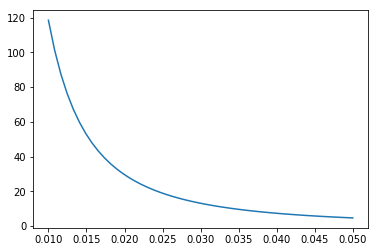

In [86]:
N = np.linspace(dmin_p_payment_upon_enroll, 0.05, 50)
size = [normal_test_sample_size(p_payment_upon_enroll, n, 0.05, 0.2) * 2 /p_enroll_upon_click/ctp_startfreetrial/40000 for n in N]
plt.plot(N, size)

* Try increase alpha

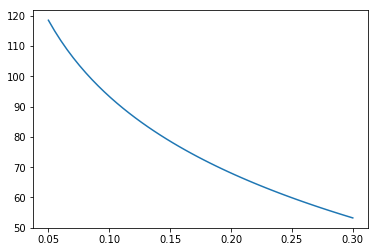

In [91]:
N = np.linspace(0.05, 0.3, 50)
size = [normal_test_sample_size(p_payment_upon_enroll, dmin_p_payment_upon_enroll, n, 0.2) * 2 /p_enroll_upon_click/ctp_startfreetrial/40000 for n in N]
plt.plot(N, size)

* Try decrease power

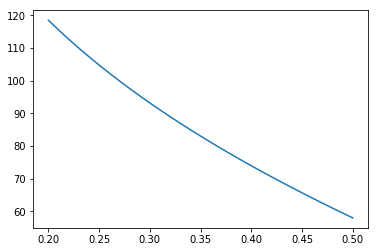

In [90]:
N = np.linspace(0.2, 0.5, 50)
size = [normal_test_sample_size(p_payment_upon_enroll, dmin_p_payment_upon_enroll, 0.05, n) * 2 /p_enroll_upon_click/ctp_startfreetrial/40000 for n in N]
plt.plot(N, size)

## 4. Sanity Check
* Two files control/experiment contain the data
* Check if the invariant metrics are true invariant

In [93]:
import pandas as pd

In [95]:
ctl = pd.read_csv('Control.csv')
exp = pd.read_csv('Experiment.csv')

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0
5,"Thu, Oct 16",9500,788,129.0,61.0
6,"Fri, Oct 17",9088,780,127.0,44.0
7,"Sat, Oct 18",7664,652,94.0,62.0
8,"Sun, Oct 19",8434,697,120.0,77.0
9,"Mon, Oct 20",10496,860,153.0,98.0
